# **MECH 3465 Robotics & Machine Intelligence - Coursework 1**

Dan Nehushtan - 201594650
<br> Louie Burns - 201588498

### Introduction
This coursework applies Convolutional Neural Networks (CNNs) to classify aircraft in remote sensing images, optimising performance through hyperparameter tuning and pre-processing. The evaluation uses the weighted F1-score to assess model improvements.

### Tasks
1. Design a convolutional neural network (CNN) for aircraft classification, justifying its suitability for the task.
2. Document the hyperparameter tuning process and analyse its impact on model performance.
3. Optimise the CNN through pre-processing techniques or alternative network structures, using weighted F1-score for evaluation.
4. Provide a detailed evaluation, comparing the initial and optimised models, including metrics and a critical reflection on results.


## **1. Dataset Preparation**

### **1.1 Importing Libraries**

In [1]:
# INSTALL MISSING LIBRARIES (This depends on device and GPU used - some stuff may already be satisfied, some may not)
%pip install datasets --quiet >NUL 2>&1
%pip install pandas --quiet >NUL 2>&1
%pip install scikit-learn --quiet >NUL 2>&1
%pip install matplotlib --quiet >NUL 2>&1
%pip install nbconvert

# Import libraries used
import os
import time
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms.functional import crop, resize, to_tensor
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from collections import Counter

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### **1.2 Prepare the device and load the model**

In [2]:
## check devices

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If CUDA is available, print the GPU name and the device being used
if torch.cuda.is_available():
    # Get the name of the current GPU
    gpu_name = torch.cuda.get_device_name(device)
    print(f"CUDA is available. Using GPU: {gpu_name}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: NVIDIA GeForce RTX 2060 SUPER


### **1.3 Loading and Preprocessing the Dataset**
*   Load the AircraftRecognition Dataset
*   Split into training and testing segments
*   The training segment is used for training the model, while the testing portion of the data is used to evaluate the accuracy of the model.

The dataset is extracted to the directory /AircraftRecognitionDataset. You need to create a local dirctory data folder. It contains 1 folder, images, containing all train and test set (10,000 images). Also it contains 19 text files which categorise the images. Verify this using os.listdir.

In [3]:
import zipfile

# Define the path to the zip file
zip_file_path = 'AircraftRecognitionDataset.zip'
extracted_folder_path = 'AircraftRecognitionDataset'  # Folder where you want to extract

# Check if the folder exists, if not, create it
if not os.path.exists(extracted_folder_path):
    os.makedirs(extracted_folder_path)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

print(f'Zip file extracted to: {extracted_folder_path}')

# Set the path to the extracted 'dataoriginal' folder
data_dir = os.path.join(extracted_folder_path, 'dataoriginal')  # Path to the dataset folder inside extracted

# List the text files in 'dataoriginal'
txt_files = [f for f in os.listdir(data_dir) if f.endswith(".txt")]
print("Text files found:", len(txt_files))

Zip file extracted to: AircraftRecognitionDataset
Text files found: 19


**This depends on where the dataset is located locally.**

In [4]:
# Define the folder containing the images
image_folder = './AircraftRecognitionDataset/dataoriginal/images'

# Paths to the text files
train_label_file = './AircraftRecognitionDataset/dataoriginal/images_manufacturer_train.txt'
test_label_file = './AircraftRecognitionDataset/dataoriginal/images_manufacturer_test.txt'
val_label_file = './AircraftRecognitionDataset/dataoriginal/images_manufacturer_trainval.txt'

In [5]:
# Define label mapping
label_mapping = {
    "Boeing": 0,
    "Airbus": 1,
    "ATR": 2,
    "Cessna": 3,
    "Embraer": 4
}

# Define transformations for image processing
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor(),          # Convert to tensor
])

def filter_data(label_file, selected_labels):
    image_data = []
    labels = []

    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split(maxsplit=1)
            if len(parts) != 2:
                continue  # Skip malformed lines
            filename, label = parts
            if label in selected_labels:
                image_path = os.path.join(image_folder, filename + ".jpg")
                try:
                    if os.path.exists(image_path):
                        image = Image.open(image_path).convert("RGB")
                        image_tensor = transform(image)
                        image_data.append(image_tensor)
                        labels.append(selected_labels[label])
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    # Convert lists to PyTorch tensors
    image_tensor = torch.stack(image_data)
    label_tensor = torch.tensor(labels, dtype=torch.long)

    return image_tensor, label_tensor, labels

### **1.3 Exploratory Data Analysis (EDA)**
Visualise class distributions, dataset sizes, and other statistics.

In [6]:
# Process training, validation, and test data for selected labels
train_image_tensor, train_label_tensor, train_labels = filter_data(train_label_file, label_mapping)
val_image_tensor, val_label_tensor, val_labels = filter_data(val_label_file, label_mapping)
test_image_tensor, test_label_tensor, test_labels = filter_data(test_label_file, label_mapping)

# Print dataset sizes
print(f"Number of training images: {len(train_image_tensor)}")
print(f"Number of validation images: {len(val_image_tensor)}")
print(f"Number of test images: {len(test_image_tensor)}")

# Print counts for each class in training, validation, and test datasets
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

print("Training dataset class distribution:")
for label, count in train_counts.items():
    print(f"{list(label_mapping.keys())[list(label_mapping.values()).index(label)]}: {count}")

print("Validation dataset class distribution:")
for label, count in val_counts.items():
    print(f"{list(label_mapping.keys())[list(label_mapping.values()).index(label)]}: {count}")

print("Test dataset class distribution:")
for label, count in test_counts.items():
    print(f"{list(label_mapping.keys())[list(label_mapping.values()).index(label)]}: {count}")

# Create TensorDatasets
train_dataset = TensorDataset(train_image_tensor, train_label_tensor)
val_dataset = TensorDataset(val_image_tensor, val_label_tensor)
test_dataset = TensorDataset(test_image_tensor, test_label_tensor)

# Example usage of DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

print("DataLoaders for selected labels created successfully.")

Number of training images: 1599
Number of validation images: 3199
Number of test images: 1601
Training dataset class distribution:
Boeing: 733
Airbus: 434
ATR: 66
Cessna: 133
Embraer: 233
Validation dataset class distribution:
Boeing: 1466
Airbus: 867
ATR: 133
Cessna: 266
Embraer: 467
Test dataset class distribution:
Boeing: 734
Airbus: 433
ATR: 67
Cessna: 134
Embraer: 233
DataLoaders for selected labels created successfully.


## **2. Model Development**

### **2.1 Initial Model Design**
Define the initial CNN architecture and explain the design choices.

In [7]:
# Define a simplified CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 32 * 32, len(label_mapping))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x

# Instantiate the simplified model
model = SimpleCNN()

### **2.2 Training Process**
Train the initial model and validate its performance.

In [8]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 15
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
f1_scores = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    test_accuracy = correct_test / total_test
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Store metrics
    train_losses.append(running_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    f1_scores.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}, F1 Score: {f1:.4f}")

print("Training complete.")

# Plotting results
epochs = range(1, num_epochs + 1)

Epoch [1/15], Train Loss: 1.4191, Test Loss: 1.3897, Train Acc: 0.4043, Test Acc: 0.2706, F1 Score: 0.1153
Epoch [2/15], Train Loss: 1.3495, Test Loss: 1.3638, Train Acc: 0.4329, Test Acc: 0.3569, F1 Score: 0.3084
Epoch [3/15], Train Loss: 1.3286, Test Loss: 1.3268, Train Acc: 0.4512, Test Acc: 0.4587, F1 Score: 0.2885
Epoch [4/15], Train Loss: 1.3249, Test Loss: 1.3296, Train Acc: 0.4603, Test Acc: 0.4581, F1 Score: 0.3114
Epoch [5/15], Train Loss: 1.3173, Test Loss: 1.3229, Train Acc: 0.4577, Test Acc: 0.4587, F1 Score: 0.2885
Epoch [6/15], Train Loss: 1.3157, Test Loss: 1.3440, Train Acc: 0.4531, Test Acc: 0.3956, F1 Score: 0.3386
Epoch [7/15], Train Loss: 1.3105, Test Loss: 1.3284, Train Acc: 0.4531, Test Acc: 0.4581, F1 Score: 0.3102
Epoch [8/15], Train Loss: 1.3052, Test Loss: 1.3142, Train Acc: 0.4668, Test Acc: 0.4587, F1 Score: 0.2885
Epoch [9/15], Train Loss: 1.2976, Test Loss: 1.3127, Train Acc: 0.4616, Test Acc: 0.4612, F1 Score: 0.3064
Epoch [10/15], Train Loss: 1.2908, Te

### **2.3 Metrics for Initial Model**
Visualise the performance of the initial model using metrics like accuracy and F1-score.

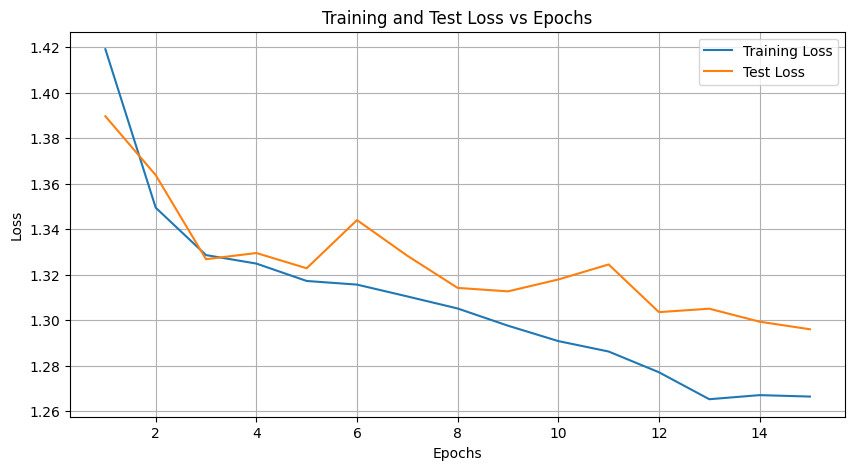

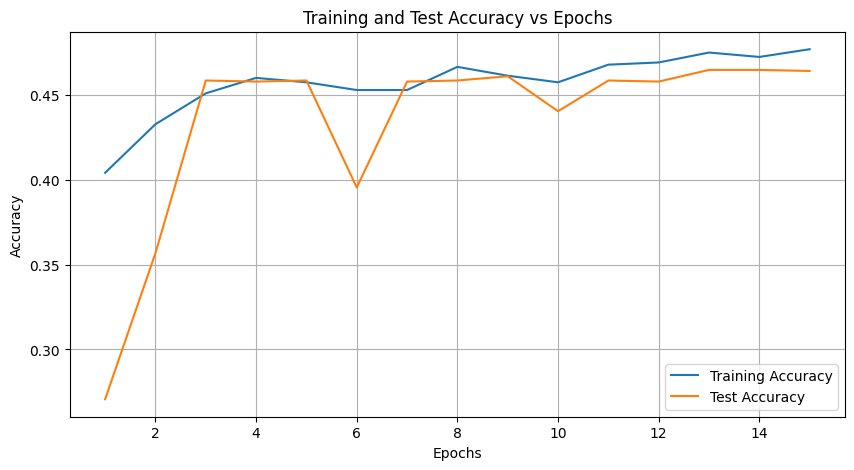

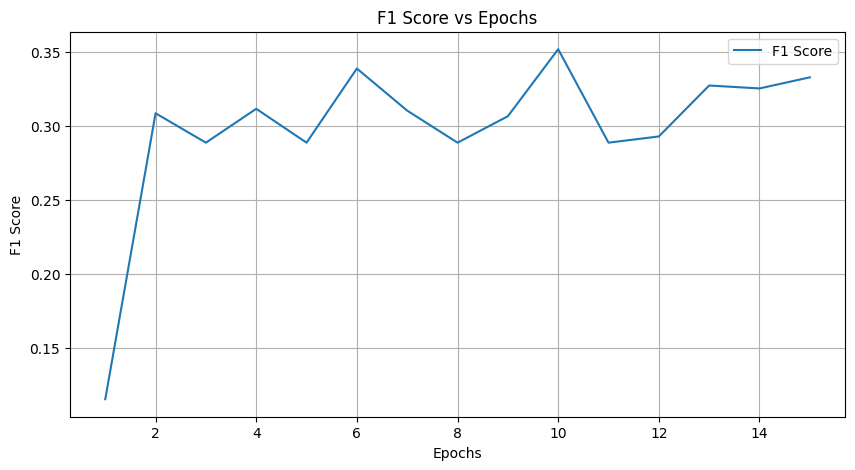

In [9]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()  

# Plot F1 Score
plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_scores, label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

## **3. Model Optimisation**

### **3.1 Hyperparameter Tuning**
Adjust hyperparameters such as learning rate, batch size, and architecture details.

First we will increase the number of manufacturers mapped for training.

In [10]:
# Define label mapping
label_mapping = {
    "Boeing": 0,
    "Airbus": 1,
    "ATR": 2,
    "Antonov": 3,
    "BritishAerospace": 4,
    "Beechcraft": 5,
    "LockheedCorporation": 6,
    "DouglasAircraftCompany": 7,
    "Canadair": 8,
    "Cessna": 9,
    "McDonnellDouglas": 10,
    "deHavilland": 11,
    "Robin": 12,
    "Dornier": 13,
    "Embraer": 14,
    "Eurofighter": 15,
    "LockheedMartin": 16,
    "DassaultAviation": 17,
    "Fokker": 18,
    "BombardierAerospace": 19,
    "GulfstreamAerospace": 20,
    "Ilyushin": 21,
    "Fairchild": 22,
    "Piper": 23,
    "CirrusAircraft": 24,
    "Saab": 25,
    "Supermarine": 26,
    "Panavia": 27,
    "Tupolev": 28,
    "Yakovlev": 29
}

def select_balanced_classes(train_file, val_file, test_file, label_mapping, num_classes=5):
    def count_labels(file_path):
        counts = Counter()
        with open(file_path, "r") as f:
            for line in f:
                _, label = line.strip().split(maxsplit=1)
                if label in label_mapping:
                    counts[label] += 1
        return counts

    train_counts = count_labels(train_file)
    val_counts = count_labels(val_file)
    test_counts = count_labels(test_file)

    # Combine counts for all datasets
    combined_counts = {label: train_counts[label] + val_counts[label] + test_counts[label] for label in label_mapping}
    
    # Sort by total count and select top labels
    selected_labels = dict(sorted(combined_counts.items(), key=lambda item: item[1], reverse=True)[:num_classes])
    
    # Map selected labels to indices
    selected_labels = {label: idx for idx, (label, _) in enumerate(selected_labels.items())}

    return selected_labels

# Intelligently select classes based on data distribution
selected_labels = select_balanced_classes(train_label_file, val_label_file, test_label_file, label_mapping)

In [11]:
# Define transformations for image processing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(5),    # Random rotation up to 15 degrees
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize
])

def filter_data(label_file, selected_labels):
    image_data = []
    labels = []

    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split(maxsplit=1)
            if len(parts) != 2:
                continue  # Skip malformed lines
            filename, label = parts
            if label in selected_labels:
                image_path = os.path.join(image_folder, filename + ".jpg")
                try:
                    if os.path.exists(image_path):
                        image = Image.open(image_path).convert("RGB")
                        image_tensor = transform(image)
                        image_data.append(image_tensor)
                        labels.append(selected_labels[label])
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    # Convert lists to PyTorch tensors
    image_tensor = torch.stack(image_data)
    label_tensor = torch.tensor(labels, dtype=torch.long)

    return image_tensor, label_tensor, labels


# Process training, validation, and test data for selected labels
train_image_tensor, train_label_tensor, train_labels = filter_data(train_label_file, selected_labels)
val_image_tensor, val_label_tensor, val_labels = filter_data(val_label_file, selected_labels)
test_image_tensor, test_label_tensor, test_labels = filter_data(test_label_file, selected_labels)

# Print dataset sizes
print(f"Number of training images: {len(train_image_tensor)}")
print(f"Number of validation images: {len(val_image_tensor)}")
print(f"Number of test images: {len(test_image_tensor)}")

# Print counts for each class in training, validation, and test datasets
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

print("Training dataset class distribution:")
for label, count in train_counts.items():
    print(f"{list(selected_labels.keys())[list(selected_labels.values()).index(label)]}: {count}")

print("Validation dataset class distribution:")
for label, count in val_counts.items():
    print(f"{list(selected_labels.keys())[list(selected_labels.values()).index(label)]}: {count}")

print("Test dataset class distribution:")
for label, count in test_counts.items():
    print(f"{list(selected_labels.keys())[list(selected_labels.values()).index(label)]}: {count}")

# Create TensorDatasets
train_dataset = TensorDataset(train_image_tensor, train_label_tensor)
val_dataset = TensorDataset(val_image_tensor, val_label_tensor)
test_dataset = TensorDataset(test_image_tensor, test_label_tensor)

# Example usage of DataLoader
batch_size = 32  # Increased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("DataLoaders for selected labels created successfully.")

Number of training images: 1667
Number of validation images: 3333
Number of test images: 1667
Training dataset class distribution:
Boeing: 733
Airbus: 434
Canadair: 134
Cessna: 133
Embraer: 233
Validation dataset class distribution:
Boeing: 1466
Airbus: 867
Canadair: 267
Cessna: 266
Embraer: 467
Test dataset class distribution:
Boeing: 734
Airbus: 433
Canadair: 133
Cessna: 134
Embraer: 233
DataLoaders for selected labels created successfully.


### **3.2 Improved Model Design**
Define the optimised CNN architecture with improved performance.

In [12]:
# Define a simplified CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, len(selected_labels))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 64 * 64, len(selected_labels))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = x.view(-1, 16 * 64 * 64)
        x = self.fc1(x)
        return x

# Instantiate the simplified model
model = SimpleCNN()

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Fixed learning rate

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.5)  # Decays learning rate by 0.5 every 9 epochs

# Lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
f1_scores = []
learning_rates = []

# Training loop
num_epochs = 40  # Increased number of epochs
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Step the scheduler
    scheduler.step()
    learning_rates.append(scheduler.get_last_lr()[0])

    train_accuracy = correct_train / total_train

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    test_accuracy = correct_test / total_test
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Store metrics
    train_losses.append(running_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    f1_scores.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}, F1 Score: {f1:.4f}, Learning Rate: {scheduler.get_last_lr()[0]}")

print("Training complete.")

# Create Epochs for plotting results
epochs = range(1, num_epochs + 1)

Epoch [1/40], Train Loss: 9.1959, Test Loss: 2.0513, Train Acc: 0.3641, Test Acc: 0.4121, F1 Score: 0.3307, Learning Rate: 0.01
Epoch [2/40], Train Loss: 1.3687, Test Loss: 2.4558, Train Acc: 0.4583, Test Acc: 0.1776, F1 Score: 0.1606, Learning Rate: 0.01
Epoch [3/40], Train Loss: 1.1897, Test Loss: 1.4528, Train Acc: 0.5159, Test Acc: 0.4037, F1 Score: 0.3963, Learning Rate: 0.01
Epoch [4/40], Train Loss: 1.0382, Test Loss: 2.3682, Train Acc: 0.5615, Test Acc: 0.3431, F1 Score: 0.2831, Learning Rate: 0.01
Epoch [5/40], Train Loss: 1.0304, Test Loss: 3.0175, Train Acc: 0.6023, Test Acc: 0.2675, F1 Score: 0.1386, Learning Rate: 0.01
Epoch [6/40], Train Loss: 0.9436, Test Loss: 2.4723, Train Acc: 0.6371, Test Acc: 0.2801, F1 Score: 0.1495, Learning Rate: 0.01
Epoch [7/40], Train Loss: 0.8308, Test Loss: 1.5123, Train Acc: 0.6893, Test Acc: 0.4721, F1 Score: 0.4305, Learning Rate: 0.01
Epoch [8/40], Train Loss: 0.6985, Test Loss: 1.9315, Train Acc: 0.7367, Test Acc: 0.3773, F1 Score: 0.34

### **3.3 Metrics for Improved Model**
Visualise the performance of this improved model using metrics like accuracy and F1-score.

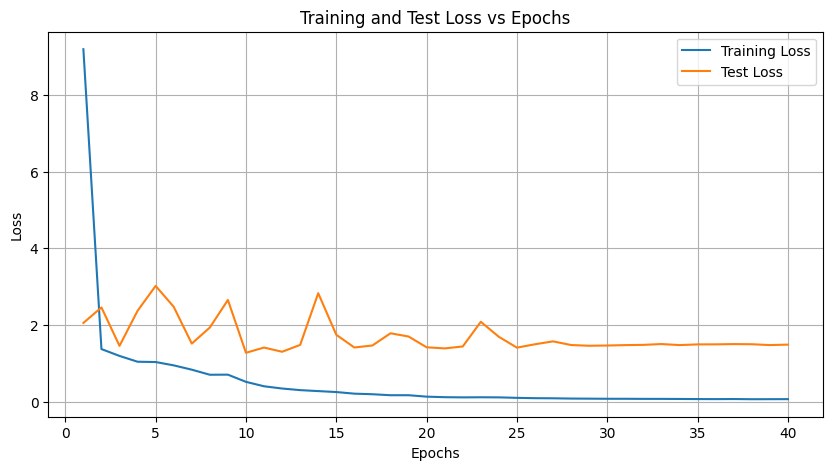

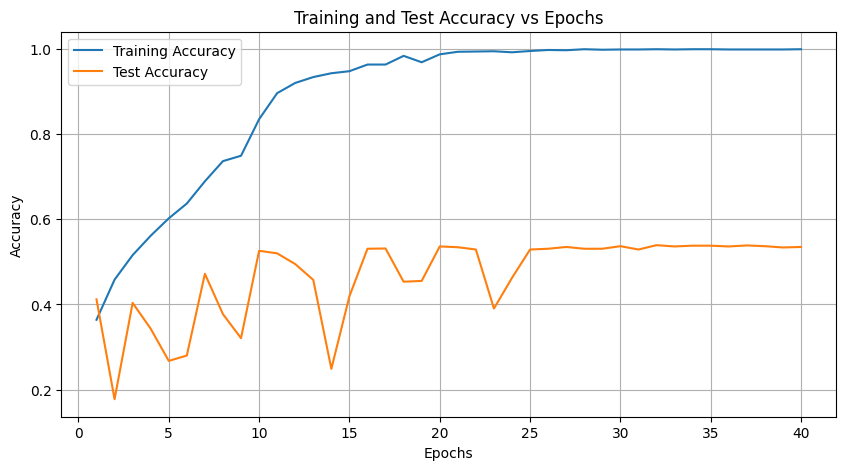

In [14]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

## **4. Results and Evaluation**

### **4.1 Metrics Comparison**
Compare the performance of the initial and optimised models primarily using metrics like F1-score.

Generate plots for metrics and training curves.


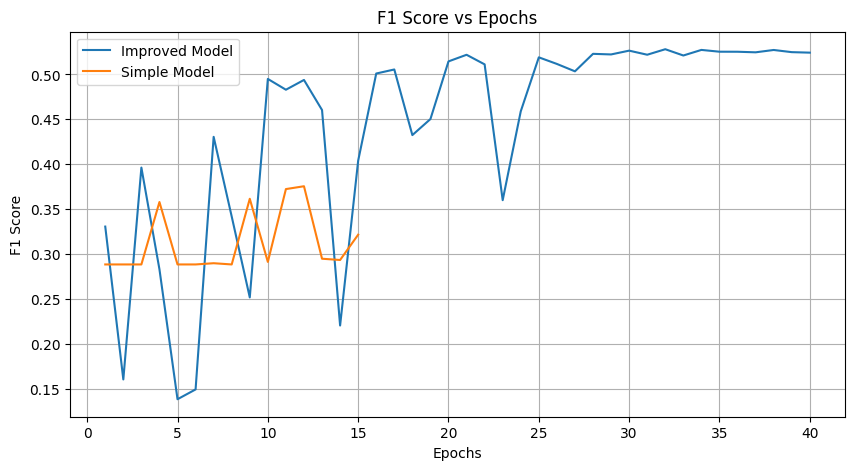

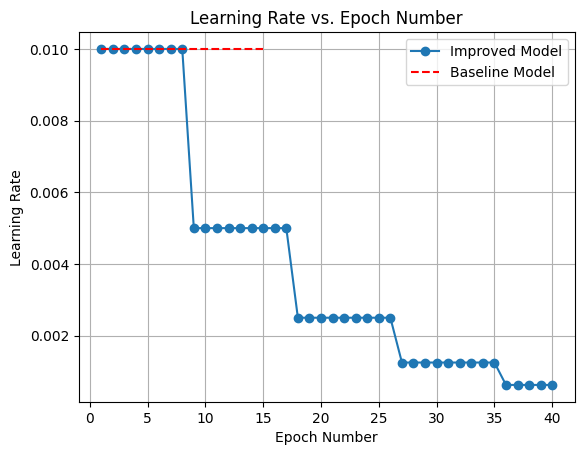

In [15]:
# Plot F1 Score
plt.figure(figsize=(10, 5))

# Improved Model F1 Scores
plt.plot(epochs, f1_scores, linestyle='-', label="Improved Model")

# Plot the F1 values from the Baseline Model, this is hard-coded in
plt.plot(
    range(1, 16), 
    [0.2885368466152528, 0.2885368466152528, 0.2885368466152528, 0.35800560282056604, 
     0.2885368466152528, 0.2885368466152528, 0.28990515812498047, 0.2885368466152528, 
     0.36161119202439296, 0.2913618247972723, 0.3724076408386039, 0.3755616336834515, 
     0.29490095228198265, 0.29349818381047593, 0.32165556746495966], linestyle='-', label="Simple Model"
)

# Formatting the plot
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

baseline = [0.01] * 15

# Plot improved model (all 50 epochs)
plt.plot(range(1, num_epochs + 1), learning_rates, marker='o', linestyle='-', label="Improved Model")
# Plot baseline model (up to epoch 15)
plt.plot(range(1, 16), baseline, linestyle='--', color='red', label="Baseline Model")
plt.title("Learning Rate vs. Epoch Number")
plt.xlabel("Epoch Number")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.legend()
plt.show()

### **4.2 Discussion**

**All in the Word Document - Report**